In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from auganise import mixup

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)

In [3]:
BATCH_SIZE = 64
EPOCHS = 10

In [4]:
# Put aside a few samples to create our validation set
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [5]:
train_ds_mu = mixup.augment(train_ds, alpha=0.2)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011806127615272999, 0.0, 0.9881938695907593]
[0.0, 0.0, 0.0, 0.01798318326473236, 0.0, 0.0, 0.0, 0.9820168018341064, 0.0, 0.0]
[0.0, 0.24327221512794495, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7567278146743774, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.06523436307907104, 0.0, 0.934765636920929, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.19799473881721497, 0.8020052909851074, 0.0, 0.0, 0.0, 0.0]
[0.9314286708831787, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06857135891914368, 0.0]
[0.0, 0.0, 0.0, 0.8535945415496826, 0.0, 0.0, 0.14640548825263977, 0.0, 0.0, 0.0]
[0.0, 0.7979378700256348, 0.0, 0.0, 0.0, 0.20206211507320404, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.9695500135421753, 0.0, 0.030449986457824707, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


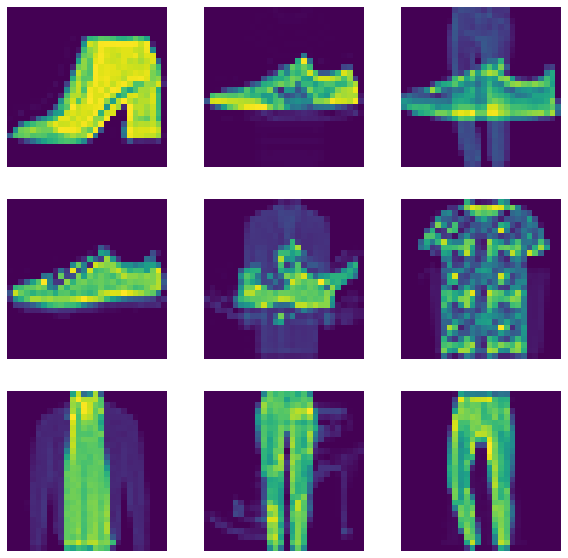

In [6]:
# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

In [8]:
def get_training_model():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(16, (5, 5), activation="relu", input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.GlobalAvgPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

In [9]:
initial_model = get_training_model()
initial_model.save_weights("initial_weights.h5")

In [10]:
model = get_training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_mu, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
907/907 [==============================] - 26s 28ms/step - loss: 1.3981 - accuracy: 0.5508 - val_loss: 0.6587 - val_accuracy: 0.7610
Epoch 2/10
907/907 [==============================] - 22s 24ms/step - loss: 0.9346 - accuracy: 0.7306 - val_loss: 0.5426 - val_accuracy: 0.8110
Epoch 3/10
907/907 [==============================] - 25s 27ms/step - loss: 0.8476 - accuracy: 0.7731 - val_loss: 0.4815 - val_accuracy: 0.8395
Epoch 4/10
907/907 [==============================] - 25s 28ms/step - loss: 0.7913 - accuracy: 0.7962 - val_loss: 0.4254 - val_accuracy: 0.8575
Epoch 5/10
907/907 [==============================] - 24s 27ms/step - loss: 0.7532 - accuracy: 0.8063 - val_loss: 0.4021 - val_accuracy: 0.8625
Epoch 6/10
907/907 [==============================] - 21s 23ms/step - loss: 0.7266 - accuracy: 0.8152 - val_loss: 0.3827 - val_accuracy: 0.8700
Epoch 7/10
907/907 [==============================] - 22s 24ms/step - loss: 0.7088 - accuracy: 0.8205 - val_loss: 0.3622 - val_accuracy: